# Inference: Hamiltonian MCMC

This example shows you how to perform Bayesian inference on a Normal distribution and a time-series problem, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).


First, we create a simple normal distribution

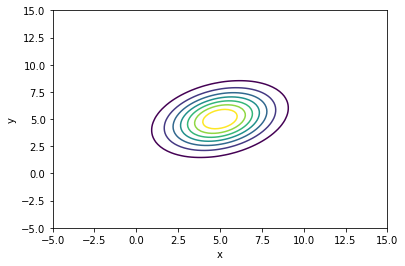

In [2]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NormalLogPDF([5, 5], [[4, -1], [1, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Hamiltonian MCMC

In [3]:
# Choose starting points for 3 mcmc chains
xs = [
    [-5, -5],
    [3, 3],
    [18, 18],
]

# Set a standard deviation, to give the method a sense of scale
sigma = [1, 1]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_pdf, 3, xs, sigma, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(100)

# Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0         0.333     0          0:00.0
2     123    0         0.5       0          0:00.0
3     183    0         0.4       0          0:00.0
100   6003   0.382     0.657     0.569      0:00.7
200   12003  0.554     0.738     0.619      0:01.5
300   18003  0.593     0.748     0.652      0:02.2
400   24003  0.619403  0.744     0.674      0:02.9
500   30003  0.643     0.745     0.669      0:03.5
600   36003  0.661     0.736     0.684      0:04.1
700   42003  0.671     0.728     0.689      0:04.7
800   48003  0.68      0.732     0.697      0:05.4
900   54003  0.684     0.723     0.694      0:06.1
1000  59943  0.686     0.727     0.691      0:06.8
Halting: Maximum number of iterations (1000) reached.
Done!


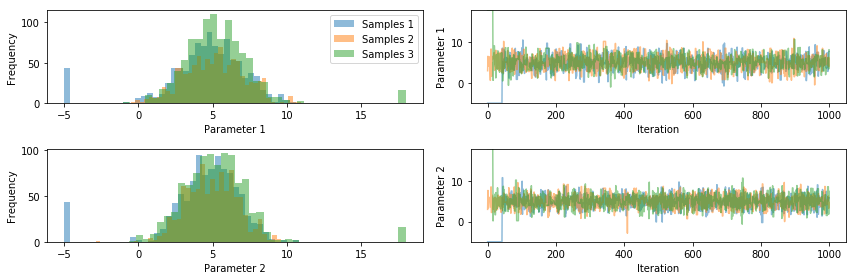

In [4]:
import pints.plot

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:]

R-hat:
[1.0007209344140418, 1.0012658601583062]


/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


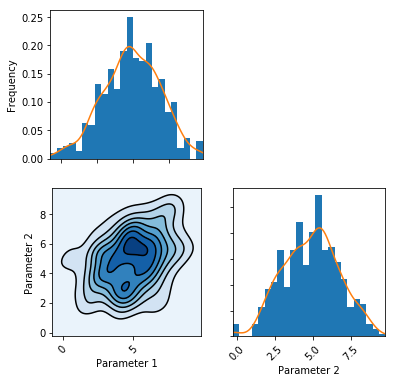

In [5]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

It seems Hamiltonian MCMC does very well at this problem!

## Hamiltonian MCMC on a banana problem

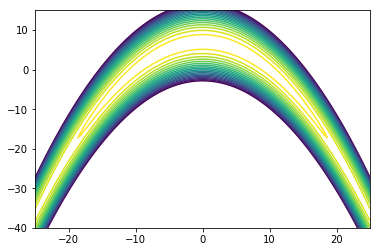

In [41]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.07)

# Contour plot of pdf
levels = np.linspace(-50, -1, 20)
x = np.linspace(-25, 25, 250)
y = np.linspace(-40, 15, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels = levels)
plt.show()

In [44]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-25, 25, size=(3, 2))
mcmc = pints.MCMCSampling(log_pdf, 3, x0, method=pints.HamiltonianMCMC)

# Stop after 10000 iterations
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[5000:] for chain in chains]

Running...
Using Hamiltonian MCMC
Generating 3 chains.
Running in sequential mode.


NotImplementedError: 

## Hamiltonian MCMC on a time-series problem

We now try the same method on a time-series problem

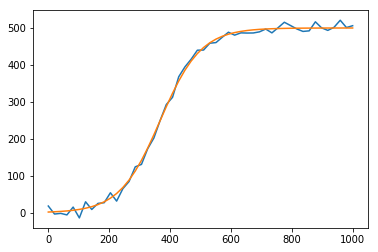

In [20]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0], 500], times)
        gradient = gradient[:, 0]
        return values, gradient
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

Maximising LogPDF
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 4
Iter. Eval. Best      Time m:s
0     4     -374.2353   0:00.0
1     8     -374.2353   0:00.0
2     12    -335.1027   0:00.0
3     16    -190.6176   0:00.0
20    84    -184.5913   0:00.0
40    164   -184.5911   0:00.0
60    244   -184.5911   0:00.0
80    324   -184.5911   0:00.0
100   404   -184.5911   0:00.0
120   484   -184.5911   0:00.1
140   564   -184.5911   0:00.1
160   644   -184.5911   0:00.1
180   724   -184.5911   0:00.1
200   804   -184.5911   0:00.1
220   884   -184.5911   0:00.1
240   964   -184.5911   0:00.1
249   996   -184.5911   0:00.1
Halting: No significant change for 200 iterations.
0.014993608593413373


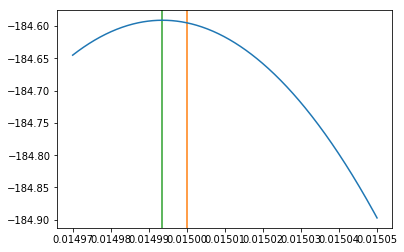

In [21]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Find the best parameters
best_parameters, fx = pints.optimise(log_likelihood, real_parameters, method=pints.XNES)
print(best_parameters[0])

# Show the likelihood near the true parameters
plt.figure()
x = np.linspace(0.01497, 0.01505, 500)
y = [log_likelihood([i]) for i in x]
plt.axvline(real_parameters[0], color='tab:orange')
plt.axvline(best_parameters[0], color='tab:green')
plt.plot(x, y)
plt.show()

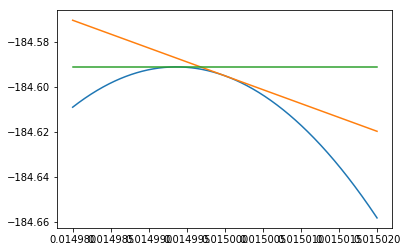

[-1235.80328256]
[0.00124244]


In [26]:
# Show derivatives at two points
y1, dy1 = log_likelihood.evaluateS1(real_parameters)
y2, dy2 = log_likelihood.evaluateS1(best_parameters)

# Show the likelihood near the true parameters
x = np.linspace(0.01498, 0.01502, 500)
y = [log_likelihood([i]) for i in x]
z1 = y1 + (x - real_parameters[0]) * dy1
z2 = y2 + (x - best_parameters[0]) * dy2

plt.figure()
#plt.axvline(real_parameters[0], color='tab:orange')
#plt.axvline(best_parameters[0], color='tab:green')
plt.plot(x, y)
plt.plot(x, z1)
plt.plot(x, z2)
plt.show()

print(dy1)
print(dy2)

In [61]:
# Choose starting points for mcmc chains
xs = [
    real_parameters * 1.01,
    #real_parameters * 0.9,
    #real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
#sigma0 = (best_parameters - real_parameters) * 0.1
sigma0 = np.abs(real_parameters)

# Create mcmc routine
mcmc = pints.MCMCSampling(
    log_likelihood, len(xs), xs, sigma0,
    method=pints.HamiltonianMCMC
    #method=pints.AdaptiveCovarianceMCMC
)

# Add stopping criterion
mcmc.set_max_iterations(5000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(250)

# Set small step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(3e-5)   # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     21     0.333      0:00.0
2     41     0.5        0:00.0
3     61     0.6        0:00.0
250   5001   0.972      0:01.2
500   10001  0.978      0:02.4
750   15001  0.984      0:03.7
1000  20001  0.987      0:04.8
1250  25001  0.988      0:06.0
1500  30001  0.985      0:07.2
1750  35001  0.986      0:08.4
2000  40001  0.985      0:09.6
2250  45001  0.985      0:10.8
2500  50001  0.984      0:12.0
2750  55001  0.984      0:13.1
3000  60001  0.983      0:14.3
3250  65001  0.984      0:15.5
3500  70001  0.982      0:16.6
3750  75001  0.981      0:17.8
4000  80001  0.982      0:19.0
4250  85001  0.981      0:20.1
4500  90001  0.981      0:21.3
4750  95001  0.98       0:22.5
5000  99981  0.980004   0:23.6
Halting: Maximum number of iterations (5000) reached.
Done!


(1, 1000, 2)


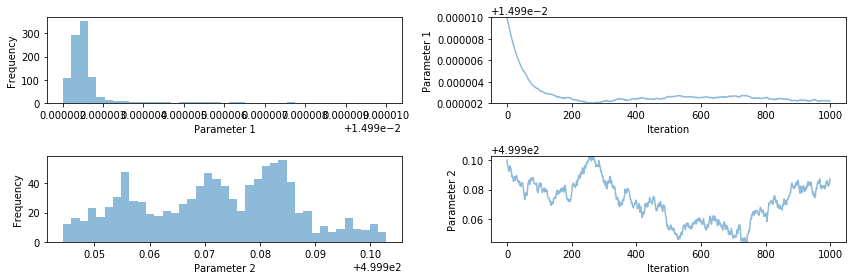

In [48]:
# Show traces and histograms
print(chains.shape)
pints.plot.trace(chains)

plt.show()

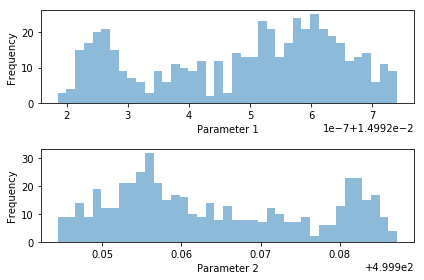

In [49]:
# Look at distribution in chain 0
pints.plot.histogram(chains[:, 500:])

# Show graphs
plt.show()

## 2d Time series

In [89]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    #real_parameters * 0.9,
    #real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
sigma0 = np.abs(real_parameters) * 1

# Create mcmc routine
mcmc = pints.MCMCSampling(
        log_posterior, len(xs), xs, sigma0=sigma0,
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(500)

# Set up step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(3.1e-5)    # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     21     0.333      0:00.0
2     41     0.5        0:00.0
3     61     0.6        0:00.0
500   10001  0.884      0:02.6
1000  20001  0.901      0:05.2
1500  30001  0.902      0:07.8
2000  40001  0.901      0:10.4
2500  50001  0.897      0:13.0
3000  60001  0.899      0:15.6
3500  70001  0.896916   0:18.2
4000  80001  0.898      0:20.8
4500  90001  0.896      0:23.4
5000  100001  0.895      0:26.0
5500  110001  0.897      0:28.6
6000  120001  0.896      0:31.1
6500  130001  0.896      0:33.7
7000  140001  0.896      0:36.4
7500  150001  0.897494   0:39.1
8000  160001  0.899      0:41.7
8500  170001  0.9        0:44.3
9000  180001  0.902      0:46.8
9500  190001  0.903      0:49.3
10000 199981  0.904      0:51.9
Halting: Maximum number of iterations (10000) reached.
Done!


(<Figure size 864x288 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08ed25ef28>,
       dtype=object))

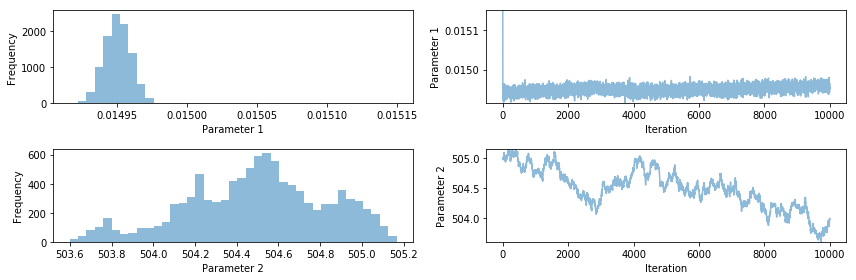

In [90]:
# Show traces and histograms
pints.plot.trace(chains)